`TTbarResCoffea` Notebook to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
This module must be run twice: 
   1. Make the mistag rate in the "anti-tag and probe" selection 
and the expectation in the signal region from MC,
   1. Applies that mistag rate and the mod-mass procedure to the single-tag selection. 

These are all done in bins of
b-tag categories (0, 1, $\ge 2$) and rapidity ($|y| \le 1.0$, $|y| > 1.0$).
The signal region is two top-tagged jets. 
The background estimate is the single-tag selection weighted by the mistag rate from the
"anti-tag and probe" region, with the mass of the weighted jet set to a random
value from QCD MC in the 1-ttag region. 


The preselection is:
- AK4-based $H_{T} > 1100$ GeV (to be on the trigger plateau). 
- $\ge 2$ AK8 jets with AK8 $p_{T} > 400$ GeV and $|y| < 2.5$, loose jet ID applied from matched AK4 jets

The 1-tag selection adds:
- $\ge 1$ AK8 jet with top tagging applied to randomly-assigned tag jet. 


The anti-tag selection is disjoint from the 1-tag selection:
- $\ge 1$ AK8 jet with top tagging VETO applied to randomly-assigned tag jet. 


The 2-tag selection is:
- $\ge 2$ AK8 jets with top tagging applied to both leading jets. 


The ttbar candidate mass assumes the two leading top-tagged jets are the top quarks. 


In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from coffea import util
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import pandas as pd

In [2]:
xrootdstr1 = 'root://cmseos.fnal.gov//'
xrootdstr2 = 'root://cmsxrootd.fnal.gov//'
xrootdstr3 = 'root://cmsxrootd-site.fnal.gov/'

In [3]:
qcdfilename = 'QCD.txt'
with open(qcdfilename) as f:
    qcdfiles = [xrootdstr2 + s.strip() for s in f.readlines()]

In [4]:
ttbarfilename = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8.txt'
with open(ttbarfilename) as f:
    ttbarfiles = [xrootdstr1 + s.strip() for s in f.readlines()]

In [5]:
jetdatafilename = 'JetHT_Data.txt'
with open(jetdatafilename) as f:
    jetdatafiles = [xrootdstr2 + s.strip() for s in f.readlines() if "/store/data/Run2017" in s]

In [6]:
from distributed import Client
client = Client('coffea-dask.fnal.gov:8786')

In [7]:
"""@TTbarResAnaHadronic Package to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
"""
class TTbarResProcessor(processor.ProcessorABC):
    def __init__(self, htCut=1100., minMSD=105., maxMSD=210., tau32Cut=0.7, ak8PtMin=400., bdisc=0.7,
                writePredDist=True,isData=True,year=2019, UseLookUpTables=False,
                lu = None):
        
        self.htCut = htCut
        self.minMSD = minMSD
        self.maxMSD = maxMSD
        self.tau32Cut = tau32Cut
        self.ak8PtMin = ak8PtMin
        self.bdisc = bdisc
        self.writePredDist = writePredDist
        self.writeHistFile = True
        self.isData = isData
        self.year=year
        self.UseLookUpTables = UseLookUpTables
        self.lu = lu
        
        self.ttagcats = ["at", "0t", "1t", "2t"] #anti-tag, 0, 1, >=2 ttags
        self.btagcats = ["0b", "1b", "2b"]   # 0, 1, >=2 btags
        self.ycats = ['cen', 'fwd']          # Central and forward
        # Combine categories like "0bcen", "0bfwd", etc:
        self.anacats = [ t+b+y for t,b,y in itertools.product( self.ttagcats, self.btagcats, self.ycats) ]
        print(self.anacats)
        
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        cats_axis = hist.Cat("anacat", "Analysis Category")
        
        jetmass_axis = hist.Bin("jetmass", r"Jet $m$ [GeV]", 50, 0, 500)
        jetpt_axis = hist.Bin("jetpt", r"Jet $p_{T}$ [GeV]", 50, 0, 2000)
        ttbarmass_axis = hist.Bin("ttbarmass", r"$m_{t\bar{t}}$ [GeV]", 50, 0, 5000)
        jeteta_axis = hist.Bin("jeteta", r"Jet $\eta$", 50, -4, 4)
        jetphi_axis = hist.Bin("jetphi", r"Jet $\phi$", 50, -3.14, 3.14)
        jetp_axis = hist.Bin("jetp", r"Jet $p$ [GeV]", 50, 0, 5000)
        
        subjetmass_axis = hist.Bin("subjetmass", r"SubJet $m$ [GeV]", 50, 0, 500)
        subjetpt_axis = hist.Bin("subjetpt", r"SubJet $p_{T}$ [GeV]", 50, 0, 2000)
        subjeteta_axis = hist.Bin("subjeteta", r"SubJet $\eta$", 50, -4, 4)
        subjetphi_axis = hist.Bin("subjetphi", r"SubJet $\phi$", 50, -3.14, 3.14)

        self._accumulator = processor.dict_accumulator({
            'ttbarmass': hist.Hist("Counts", dataset_axis, cats_axis, ttbarmass_axis),
            'jetmass':   hist.Hist("Counts", dataset_axis, cats_axis, jetmass_axis),
            'jetpt':     hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis),
            'jeteta':    hist.Hist("Counts", dataset_axis, cats_axis, jeteta_axis),
            'jetphi':    hist.Hist("Counts", dataset_axis, cats_axis, jetphi_axis),
            
            'subjetmass':   hist.Hist("Counts", dataset_axis, cats_axis, subjetmass_axis),
            'subjetpt':     hist.Hist("Counts", dataset_axis, cats_axis, subjetpt_axis),
            'subjeteta':    hist.Hist("Counts", dataset_axis, cats_axis, subjeteta_axis),
            'subjetphi':    hist.Hist("Counts", dataset_axis, cats_axis, subjetphi_axis),
            
            'numerator': hist.Hist("Counts", dataset_axis, cats_axis, jetp_axis),
            'denominator': hist.Hist("Counts", dataset_axis, cats_axis, jetp_axis),
            'cutflow': processor.defaultdict_accumulator(int),
            
        })

            
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        
        output = self.accumulator.identity()
        
        #dataset = events.metadata['dataset']
        dataset = df['dataset']
        FatJets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'],
            eta=df['FatJet_eta'],
            phi=df['FatJet_phi'],
            mass=df['FatJet_mass'],
            msoftdrop=df['FatJet_msoftdrop'],
            jetId=df['FatJet_jetId'],
            tau1=df['FatJet_tau1'],
            tau2=df['FatJet_tau2'],
            tau3=df['FatJet_tau3'],
            tau4=df['FatJet_tau4'],
            n3b1=df['FatJet_n3b1'],
            btagDeepB=df['FatJet_btagDeepB'],
            deepTag_TvsQCD=df['FatJet_deepTag_TvsQCD'],
            deepTagMD_TvsQCD=df['FatJet_deepTagMD_TvsQCD']
            )
        # ---- Define Jets ---- #
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nSubJet'],
            pt=df['Jet_pt'],
            eta=df['Jet_eta'],
            phi=df['Jet_phi'],
            mass=df['Jet_mass']
            )
        
        # ---- Get event weights from dataset ---- #
        if 'JetHT' in dataset: # If data is used...
            evtweights = np.ones(FatJets.size) # set all "data weights" to one
        else: # if Monte Carlo dataset is used...
            evtweights = df["Generator_weight"].reshape(-1, 1).flatten()
        
        # ---- Show all events ---- #
        output['cutflow']['all events'] += FatJets.size
        
        # ---- Show all events according to which dataset it used ---- #
        if 'TTbar' in dataset:
            output['cutflow']['all ttbar events'] += FatJets.size
            output['cutflow']['number of ttbar sets'] += 1
        elif 'QCD' in dataset:
            output['cutflow']['all qcd events'] += FatJets.size
            output['cutflow']['number of qcd sets'] += 1
        elif 'JetHT' in dataset:
            output['cutflow']['all JetHT events'] += FatJets.size
            output['cutflow']['number of JetHT sets'] += 1
        else:
            print('\ndataset not found\n')
        
        # ---- Apply HT Cut ---- #
        hT = Jets.pt.sum()
        passhT = (hT > self.htCut)
        evtweights = evtweights[passhT]
        FatJets = FatJets[passhT]
        
        # ---- FatJets Info ---- #
        oneFatJet = (FatJets.counts >= 1) # at least one fat jet
        FatJets = FatJets[oneFatJet]
        evtweights = evtweights[oneFatJet]
        output['cutflow']['one FatJets'] += oneFatJet.sum()
        
        twoFatJets = (FatJets.counts >= 2)
        FatJets = FatJets[twoFatJets]
        evtweights = evtweights[twoFatJets]
        output['cutflow']['two FatJets'] += twoFatJets.sum()

        jet_id = (FatJets.jetId > 0)
        
        FatJets = FatJets[jet_id]
        output['cutflow']['jet id'] += jet_id.any().sum()
        
        jetkincut_index = (FatJets.pt > self.ak8PtMin) & (np.abs(FatJets.eta) < 2.5) # eta cut here
        FatJets = FatJets[ jetkincut_index ]
        output['cutflow']['jet kin'] += jetkincut_index.any().sum()

        twoFatJetsKin = (FatJets.counts >= 2) # Whats the difference from twoFatJets ?
        FatJets = FatJets[twoFatJetsKin]
        evtweights = evtweights[twoFatJetsKin]
        output['cutflow']['two FatJets and jet kin'] += twoFatJetsKin.sum()
        
        # ---- Randomly Select AK8 Jet as TTbar Candidate --- #
        index = JaggedArray.fromcounts(np.ones(len(FatJets), dtype='i'), np.random.randint(2, size=len(FatJets)))
        jet0 = FatJets[index]
        jet1 = FatJets[1 - index]
        
        ttbarcands = jet0.cross(jet1) #FatJets[:,0:2].distincts()
        
        # ---- Look for more than one TTbar candidate and re-broadcast releveant arrays  ---- #
        oneTTbar = (ttbarcands.counts >= 1)
        output['cutflow']['>= one oneTTbar'] += oneTTbar.sum()
        ttbarcands = ttbarcands[oneTTbar]
        evtweights = evtweights[oneTTbar]
        FatJets = FatJets[oneTTbar]
         
        # ---- Apply Delta Phi Cut ---- #
        dPhiCut = (ttbarcands.i0.p4.delta_phi(ttbarcands.i1.p4) > 2.1).flatten()
        output['cutflow']['dPhi > 2.1'] += dPhiCut.sum()
        ttbarcands = ttbarcands[dPhiCut]
        evtweights = evtweights[dPhiCut]
        FatJets = FatJets[dPhiCut] 
        
        
        # ---- Get Analysis Categories ---- # 
        # ---- They are (central, forward)   cross   (0b,1b,>=2b) ---- #
        cen = np.abs(ttbarcands.i0.p4.rapidity - ttbarcands.i1.p4.rapidity) < 1.0
        fwd = (~cen)
        tau32_i0 = np.where(ttbarcands.i0.tau2>0,ttbarcands.i0.tau3/ttbarcands.i0.tau2, 0 )
        tau32_i1 = np.where(ttbarcands.i1.tau2>0,ttbarcands.i1.tau3/ttbarcands.i1.tau2, 0 )
        taucut_i0 = tau32_i0 < self.tau32Cut
        taucut_i1 = tau32_i1 < self.tau32Cut
        mcut_i0 = (self.minMSD < ttbarcands.i0.msoftdrop) & (ttbarcands.i0.msoftdrop < self.maxMSD) 
        mcut_i1 = (self.minMSD < ttbarcands.i1.msoftdrop) & (ttbarcands.i1.msoftdrop < self.maxMSD) 

        ttag_i0 = (taucut_i0) & (mcut_i0)
        ttag_i1 = (taucut_i1) & (mcut_i1)
        antitag = (~taucut_i0) & (mcut_i0) #Probe will always be ttbarcands.i1
        ttag0 = (~ttag_i0) & (~ttag_i1)
        ttag1 = ttag_i0 ^ ttag_i1
        ttag2 = ttag_i0 & ttag_i1

        btag_i0 = (ttbarcands.i0.btagDeepB > self.bdisc)
        btag_i1 = (ttbarcands.i1.btagDeepB > self.bdisc)
        
        btag0 = (~btag_i0) & (~btag_i1)
        btag1 = btag_i0 ^ btag_i1
        btag2 = btag_i0 & btag_i1
        
        antitag_probe = np.logical_and(antitag, ttag_i1) #Found an antitag and ttagged probe pair for mistag rate
      
        regs = [cen,fwd]
        btags = [btag0,btag1,btag2]
        ttags = [antitag,ttag0,ttag1,ttag2]
        cats = [ (t&b&y).flatten() for t,b,y in itertools.product( ttags, btags, regs) ]
        
        labels_and_categories = dict(zip( self.anacats, cats ))
        ttbarmass = ttbarcands.p4.sum().mass.flatten()
        jetpt = ttbarcands.pt.flatten()
        #print('Jet pt = ', jetpt)
        jeteta = ttbarcands.eta.flatten()
        jetphi = ttbarcands.phi.flatten()
        
        weights = evtweights.flatten()
        #weights[weights < 0] = 0
        
        # ---- Define the SumW2 for MC Datasets ---- #
        if 'TTbar' in dataset:
            output['cutflow']['ttbar sumw'] += np.sum(weights)
            output['cutflow']['ttbar sumw2'] += np.sum(weights**2)
        if 'QCD' in dataset:
            output['cutflow']['qcd sumw'] += np.sum(weights)
            output['cutflow']['qcd sumw2'] += np.sum(weights**2)
        
        # ---- Define Momentum p of probe jet as the Mistag Rate variable; M(p) ---- #
        # ---- Transverse Momentum pT can also be used instead; M(pT) ---- #
        pT = ttbarcands.i1.pt.flatten()
        eta = ttbarcands.i1.eta.flatten()
        pz = np.sinh(eta)*pT
        p = np.absolute(np.sqrt(pT**2 + pz**2))
        
        # ---- Define the Numerator and Denominator for Mistag Rate ---- #
        numerator = np.where(antitag_probe, p, -9999) # If no antitag and tagged probe, move event to useless bin
        denominator = np.where(antitag, p, -9999) # If no antitag, move event to useless bin
        
        df = pd.DataFrame({"momentum":p}) # Used for finding values in LookUp Tables
        
        for ilabel,icat in labels_and_categories.items():
            ### ------------------------------------ Mistag Scaling ------------------------------------ ###
            if self.UseLookUpTables == True:
                filename = self.lu + '_at' + str(ilabel[2:]) + '.csv' # get mistag/lookup filename
                file_df = pd.read_csv(filename) # read in values from lookup table
                bin_widths = file_df['p'].values # collect bins as written in .csv file
                mtr = file_df['M(p)'].values # collect mistag rate as function of p as written in file
                wgts = 1.0 - mtr # Define weights based on mistag rates
                
                BinKey = np.arange(bin_widths.size) # Use as label for BinNumber column in the new dataframe
                Bins = np.arange(bin_widths.size+1)*100. # Temporary definition of bins as floats
                P = np.where(p>5000., 5000., p) # Avoids momentum larger than the allowed bin size; caps the momentum
                df['BinWidth'] = pd.cut(P, bins=Bins) # new dataframe column
                df['BinNumber'] = pd.cut(P, bins=Bins, labels=BinKey) # new dataframe column
                
                BinNumber = df['BinNumber'].values # Collect the Bin Numbers into a numpy array
                BinNumber = BinNumber.astype('int64') # Insures the bin numbers are integers
            
                WeightMatching = wgts[BinNumber] # Match 'wgts' with corresponding p bin using the bin number
                Weights = weights*WeightMatching # Include 'wgts' with the previously defined 'weights'
            else:
                Weights = weights # No mistag rates, no change to weights
            ###---------------------------------------------------------------------------------------------###
            output['cutflow'][ilabel] += np.sum(icat)
          
            output['ttbarmass'].fill(dataset=dataset, anacat=ilabel, 
                                ttbarmass=ttbarmass[icat],
                                weight=Weights[icat])
            output['jetpt'].fill(dataset=dataset, anacat=ilabel, 
                                jetpt=jetpt[icat],
                                weight=Weights[icat])
            output['jeteta'].fill(dataset=dataset, anacat=ilabel, 
                                jeteta=jeteta[icat],
                                weight=Weights[icat])
            output['jetphi'].fill(dataset=dataset, anacat=ilabel, 
                                jetphi=jetphi[icat],
                                weight=Weights[icat])
            output['numerator'].fill(dataset=dataset, anacat=ilabel, 
                                jetp=numerator[icat],
                                weight=Weights[icat])
            output['denominator'].fill(dataset=dataset, anacat=ilabel, 
                                jetp=denominator[icat],
                                weight=Weights[icat])
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [8]:
tstart = time.time()

filesets = {
    'QCD':qcdfiles,
    'TTbar':ttbarfiles,
    'JetHT':jetdatafiles
}

outputs_unweighted = {}

for name,files in filesets.items(): 

    print(name)
    output = processor.run_uproot_job({name:files},
                                      treename='Events',
                                      processor_instance=TTbarResProcessor(UseLookUpTables=False),
                                      #executor=processor.dask_executor,
                                      #executor=processor.iterative_executor,
                                      executor=processor.futures_executor,
                                      executor_args={
                                          'client': client, 
                                          'nano':False, 
                                          'flatten':True, 
                                          'skipbadfiles':True,
                                          'workers': 2},
                                      chunksize=50000, maxchunks=10
                                     )

    elapsed = time.time() - tstart
    outputs_unweighted[name] = output
    print(output)
    print(elapsed)
    util.save(output, 'TTbarResCoffea_' + name + '_unweighted_output.coffea')

QCD
['at0bcen', 'at0bfwd', 'at1bcen', 'at1bfwd', 'at2bcen', 'at2bfwd', '0t0bcen', '0t0bfwd', '0t1bcen', '0t1bfwd', '0t2bcen', '0t2bfwd', '1t0bcen', '1t0bfwd', '1t1bcen', '1t1bfwd', '1t2bcen', '1t2bfwd', '2t0bcen', '2t0bfwd', '2t1bcen', '2t1bfwd', '2t2bcen', '2t2bfwd']



{'ttbarmass': <Hist (dataset,anacat,ttbarmass) instance at 0x7fbab8b3ce90>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7fbac00f8090>, 'jetpt': <Hist (dataset,anacat,jetpt) instance at 0x7fbac00f8050>, 'jeteta': <Hist (dataset,anacat,jeteta) instance at 0x7fbac00f8110>, 'jetphi': <Hist (dataset,anacat,jetphi) instance at 0x7fbaba1cbe10>, 'subjetmass': <Hist (dataset,anacat,subjetmass) instance at 0x7fbac866db90>, 'subjetpt': <Hist (dataset,anacat,subjetpt) instance at 0x7fbaba26cad0>, 'subjeteta': <Hist (dataset,anacat,subjeteta) instance at 0x7fbaba26c990>, 'subjetphi': <Hist (dataset,anacat,subjetphi) instance at 0x7fbaba26c310>, 'numerator': <Hist (dataset,anacat,jetp) instance at 0x7fbaba26ca90>, 'denominator': <Hist (dataset,anacat,jetp) instance at 0x7fbaba26c750>, 'cutflow': defaultdict_accumulator(<class 'int'>, {'all events': 487331, 'all qcd events': 487331, 'number of qcd sets': 10, 'one FatJets': 19213, 'two FatJets': 18639, 'jet id': 18639, 'jet kin': 11626, '


{'ttbarmass': <Hist (dataset,anacat,ttbarmass) instance at 0x7fbab8b3c050>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7fbab8af1ed0>, 'jetpt': <Hist (dataset,anacat,jetpt) instance at 0x7fbac87188d0>, 'jeteta': <Hist (dataset,anacat,jeteta) instance at 0x7fbac8718e50>, 'jetphi': <Hist (dataset,anacat,jetphi) instance at 0x7fbaba26c9d0>, 'subjetmass': <Hist (dataset,anacat,subjetmass) instance at 0x7fbac00e8650>, 'subjetpt': <Hist (dataset,anacat,subjetpt) instance at 0x7fbac00e8790>, 'subjeteta': <Hist (dataset,anacat,subjeteta) instance at 0x7fbac00e8a90>, 'subjetphi': <Hist (dataset,anacat,subjetphi) instance at 0x7fbac00e8750>, 'numerator': <Hist (dataset,anacat,jetp) instance at 0x7fbac00e85d0>, 'denominator': <Hist (dataset,anacat,jetp) instance at 0x7fbac00e8490>, 'cutflow': defaultdict_accumulator(<class 'int'>, {'all events': 496770, 'all ttbar events': 496770, 'number of ttbar sets': 10, 'one FatJets': 64, 'two FatJets': 61, 'jet id': 61, 'jet kin': 16, 'two FatJ


{'ttbarmass': <Hist (dataset,anacat,ttbarmass) instance at 0x7fbac86c5650>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7fbac0431b50>, 'jetpt': <Hist (dataset,anacat,jetpt) instance at 0x7fbab9483e50>, 'jeteta': <Hist (dataset,anacat,jeteta) instance at 0x7fbab9483c90>, 'jetphi': <Hist (dataset,anacat,jetphi) instance at 0x7fbab8823b10>, 'subjetmass': <Hist (dataset,anacat,subjetmass) instance at 0x7fbab8ad6c50>, 'subjetpt': <Hist (dataset,anacat,subjetpt) instance at 0x7fbab87a4fd0>, 'subjeteta': <Hist (dataset,anacat,subjeteta) instance at 0x7fbab87a4f10>, 'subjetphi': <Hist (dataset,anacat,subjetphi) instance at 0x7fbab87a4f90>, 'numerator': <Hist (dataset,anacat,jetp) instance at 0x7fbab87a4e10>, 'denominator': <Hist (dataset,anacat,jetp) instance at 0x7fbab87a4d10>, 'cutflow': defaultdict_accumulator(<class 'int'>, {'all events': 499734, 'all JetHT events': 499734, 'number of JetHT sets': 10, 'one FatJets': 5243, 'two FatJets': 5159, 'jet id': 5147, 'jet kin': 3484, '

In [21]:
print('Elapsed time = ', elapsed, ' sec.')
print('Elapsed time = ', elapsed/60., ' min.')
print('Elapsed time = ', elapsed/3600., ' hrs.') 

Elapsed time =  21.71707057952881  sec.
Elapsed time =  0.36195117632548013  min.
Elapsed time =  0.006032519605424669  hrs.


In [22]:
for name,output in outputs_unweighted.items(): 
    print("-------Unweighted " + name + "--------")
    for i,j in output['cutflow'].items():        
        print( '%20s : %12d' % (i,j) )

-------Unweighted QCD--------
          all events :       487331
      all qcd events :       487331
  number of qcd sets :           10
         one FatJets :        19213
         two FatJets :        18639
              jet id :        18639
             jet kin :        11626
two FatJets and jet kin :         9059
     >= one oneTTbar :         9059
          dPhi > 2.1 :         4549
            qcd sumw :            0
           qcd sumw2 :            0
             at0bcen :          217
             at0bfwd :          200
             at1bcen :           11
             at1bfwd :            7
             at2bcen :            0
             at2bfwd :            0
             0t0bcen :         2119
             0t0bfwd :         1951
             0t1bcen :           58
             0t1bfwd :           55
             0t2bcen :            0
             0t2bfwd :            0
             1t0bcen :          191
             1t0bfwd :          166
             1t1bcen :         

In [23]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [24]:
def DoesDirectoryExist(mypath): #extra precaution (Probably overkill...)
    '''Checks to see if Directory exists before running mkdir_p'''
    import os.path
    from os import path
    
    if path.exists(mypath):
        pass
    else:
        mkdir_p(mypath)

In [25]:
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
warnings.filterwarnings("ignore")

# ---- Reiterate categories ---- #
ttagcats = ["at", "0t", "1t", "2t"]
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

list_of_cats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]

# ---- List the Histograms Here ---- #
list_of_hists = ('ttbarmass', 'jetpt', 'jeteta', 'jetphi',
                 'numerator', 'denominator')

In [26]:
import os

In [27]:
maindirectory = os.getcwd() # change accordingly

/work/TTbarAllHadUproot/MistagPlots/
QCD
at0bcen
<Hist (dataset,anacat,jetp) instance at 0x7fbaba26ca90>
<Hist (jetp) instance at 0x7fba97c67690>
<Hist (jetp) instance at 0x7fba97a8dd10>
mistag_QCD_at0bcen.png saved
QCD
at0bfwd
<Hist (dataset,anacat,jetp) instance at 0x7fbaba26ca90>
<Hist (jetp) instance at 0x7fba97958410>
<Hist (jetp) instance at 0x7fba97958e50>
mistag_QCD_at0bfwd.png saved
QCD
at1bcen
<Hist (dataset,anacat,jetp) instance at 0x7fbaba26ca90>
<Hist (jetp) instance at 0x7fba978e7c10>
<Hist (jetp) instance at 0x7fba978e7690>
mistag_QCD_at1bcen.png saved
QCD
at1bfwd
<Hist (dataset,anacat,jetp) instance at 0x7fbaba26ca90>
<Hist (jetp) instance at 0x7fba978a4550>
<Hist (jetp) instance at 0x7fba978a4c90>
mistag_QCD_at1bfwd.png saved
QCD
at2bcen
<Hist (dataset,anacat,jetp) instance at 0x7fbaba26ca90>
<Hist (jetp) instance at 0x7fba9782b790>
<Hist (jetp) instance at 0x7fba9782b810>
mistag_QCD_at2bcen.png saved
QCD
at2bfwd
<Hist (dataset,anacat,jetp) instance at 0x7fbaba26ca90>


mistag_TTbar_2t2bcen.png saved
TTbar
2t2bfwd
<Hist (dataset,anacat,jetp) instance at 0x7fbac00e85d0>
<Hist (jetp) instance at 0x7fbab8103710>
<Hist (jetp) instance at 0x7fbab8931ad0>
mistag_TTbar_2t2bfwd.png saved
JetHT
at0bcen
<Hist (dataset,anacat,jetp) instance at 0x7fbab87a4e10>
<Hist (jetp) instance at 0x7fbab90b2b50>
<Hist (jetp) instance at 0x7fbab90b2f10>
mistag_JetHT_at0bcen.png saved
JetHT
at0bfwd
<Hist (dataset,anacat,jetp) instance at 0x7fbab87a4e10>
<Hist (jetp) instance at 0x7fbab8b48510>
<Hist (jetp) instance at 0x7fbab8b484d0>
mistag_JetHT_at0bfwd.png saved
JetHT
at1bcen
<Hist (dataset,anacat,jetp) instance at 0x7fbab87a4e10>
<Hist (jetp) instance at 0x7fbab90c1a10>
<Hist (jetp) instance at 0x7fbab935e550>
mistag_JetHT_at1bcen.png saved
JetHT
at1bfwd
<Hist (dataset,anacat,jetp) instance at 0x7fbab87a4e10>
<Hist (jetp) instance at 0x7fba97d9ba10>
<Hist (jetp) instance at 0x7fba97d9b0d0>
mistag_JetHT_at1bfwd.png saved
JetHT
at2bcen
<Hist (dataset,anacat,jetp) instance at 

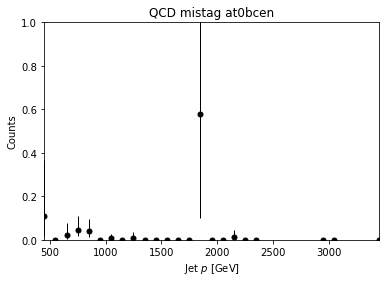

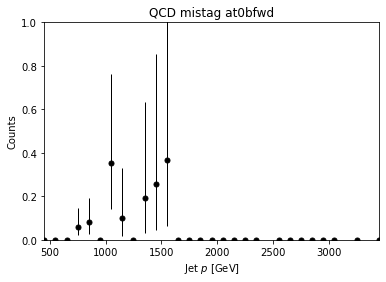

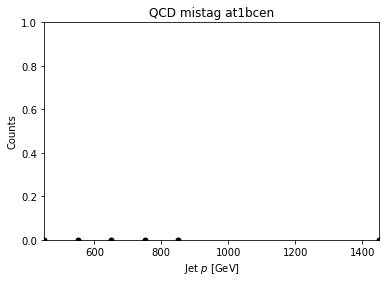

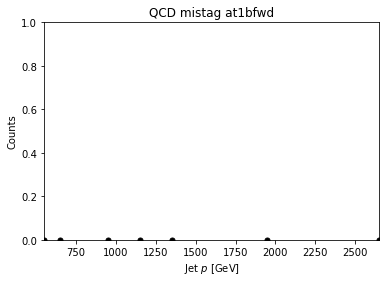

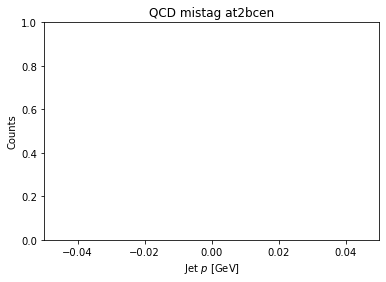

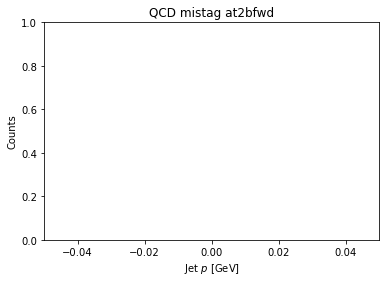

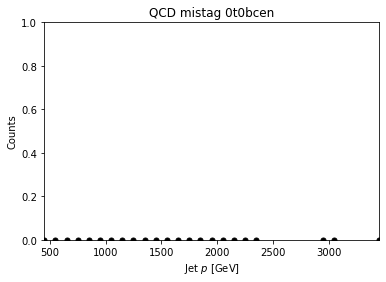

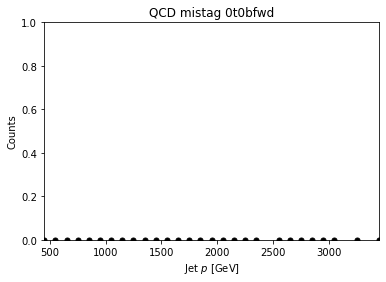

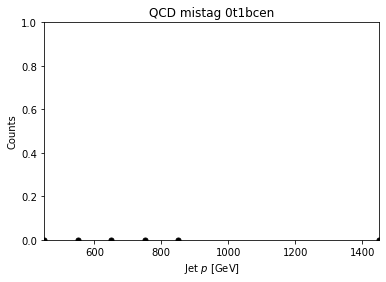

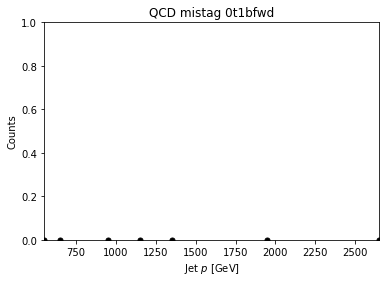

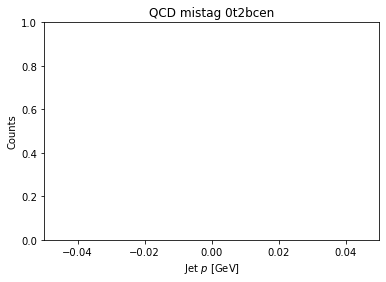

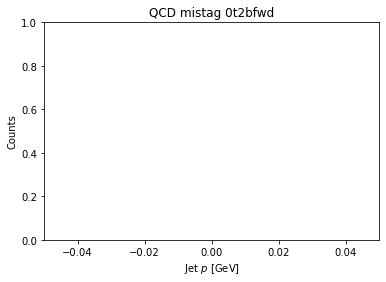

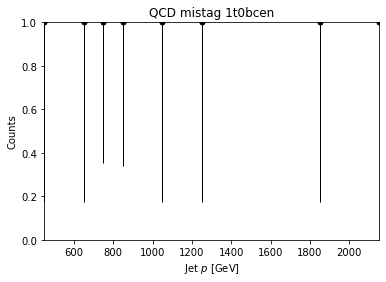

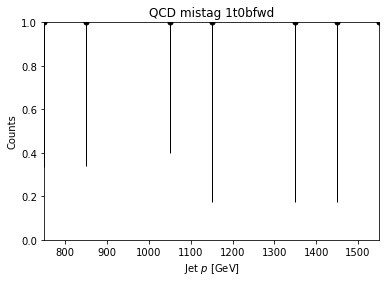

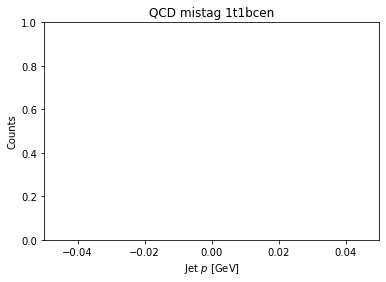

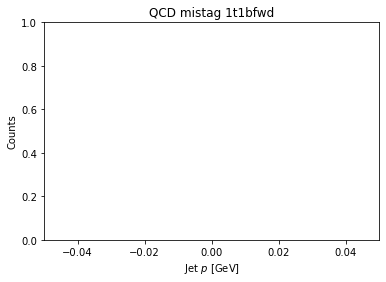

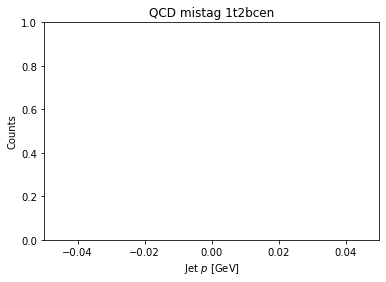

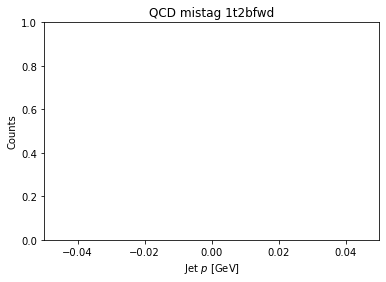

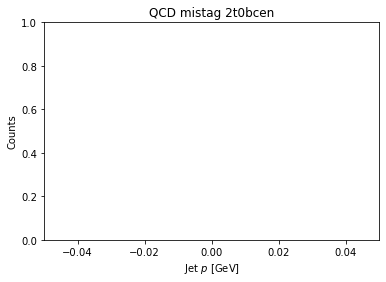

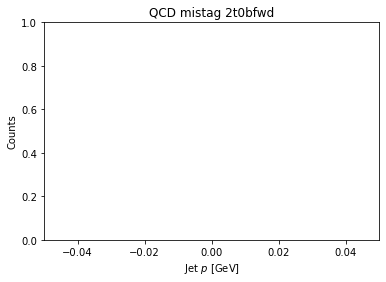

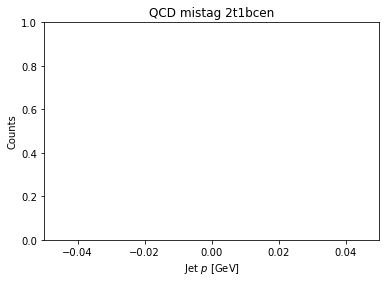

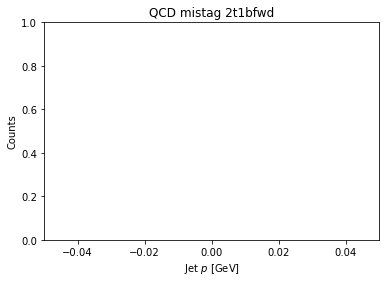

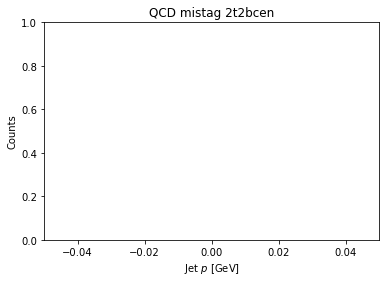

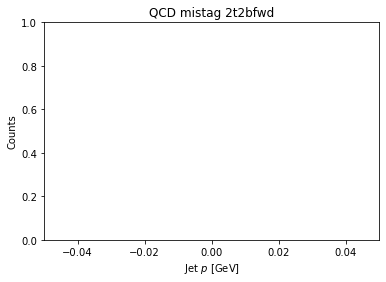

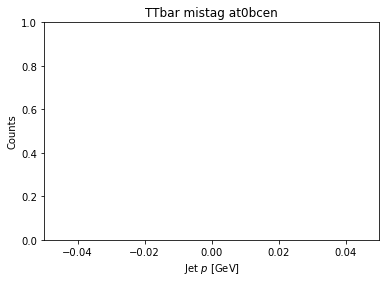

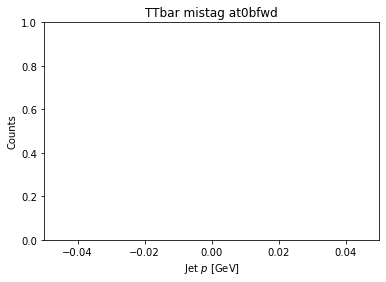

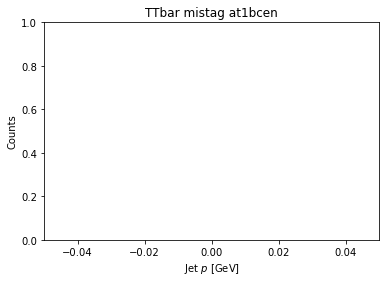

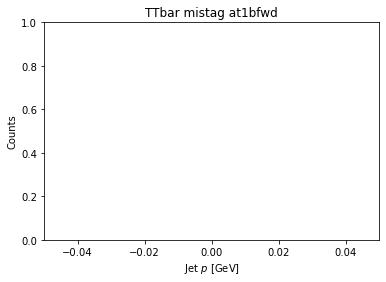

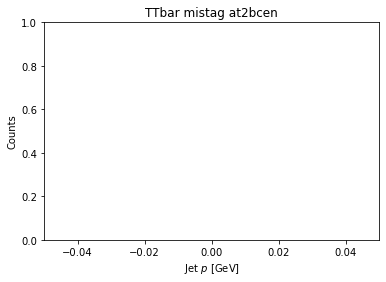

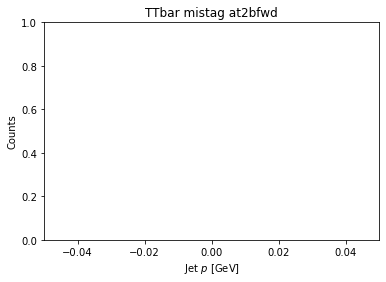

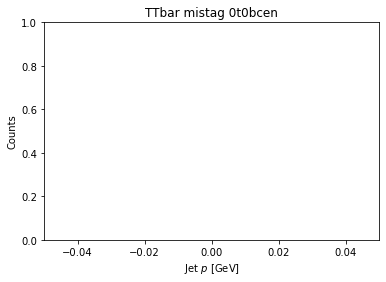

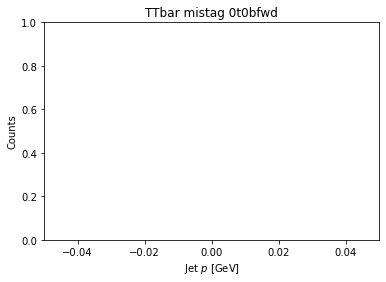

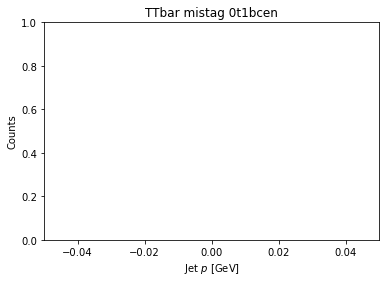

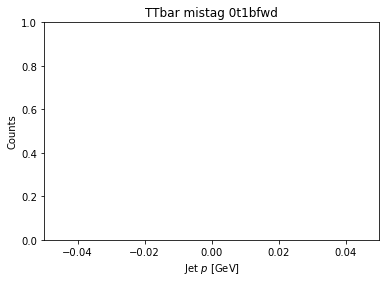

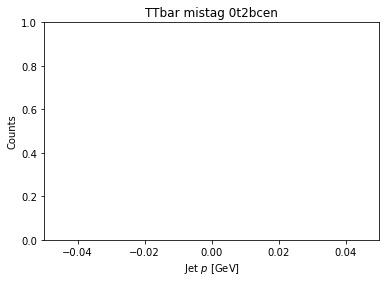

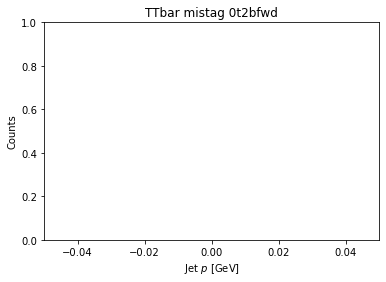

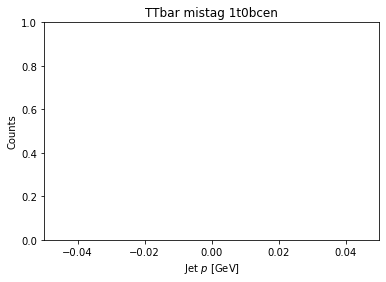

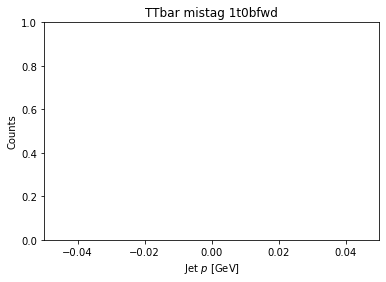

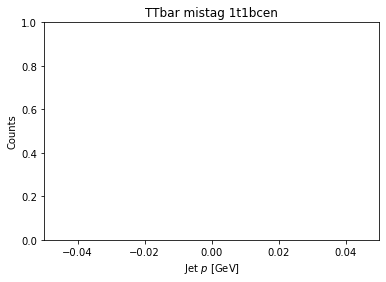

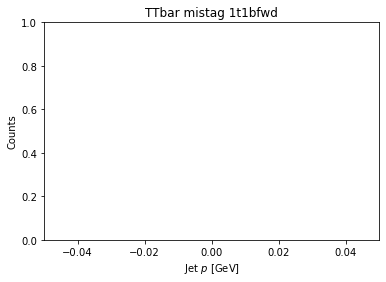

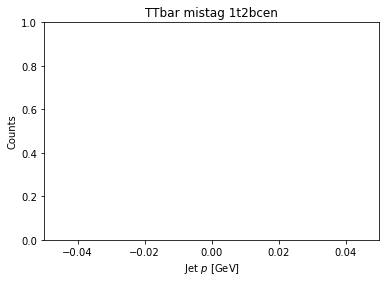

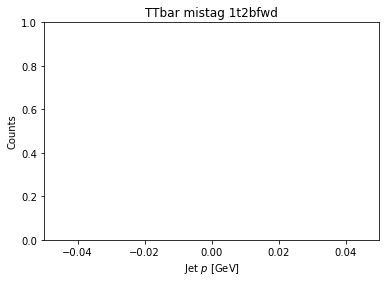

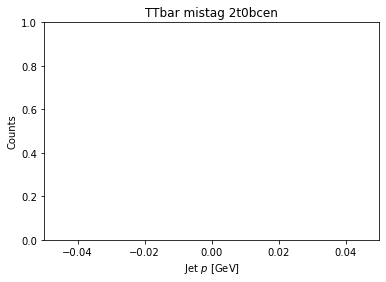

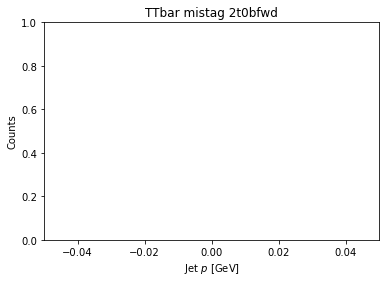

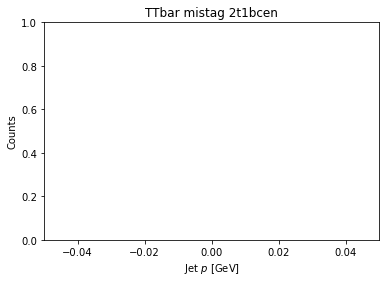

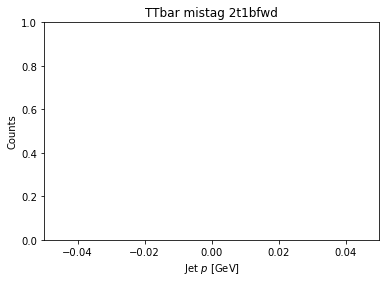

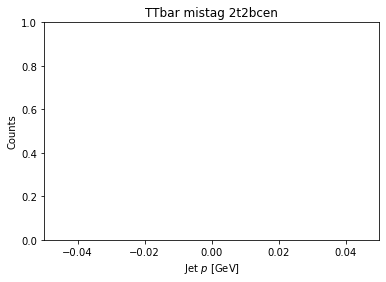

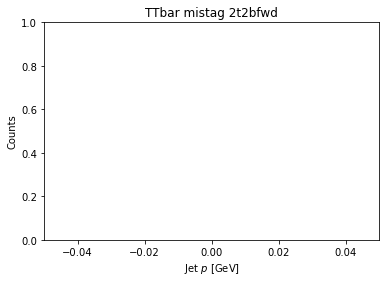

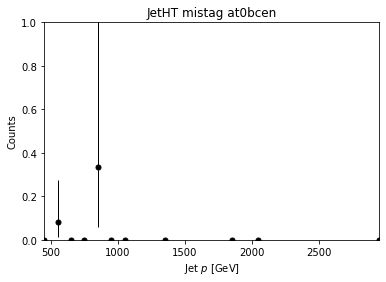

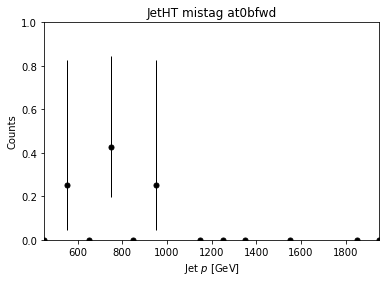

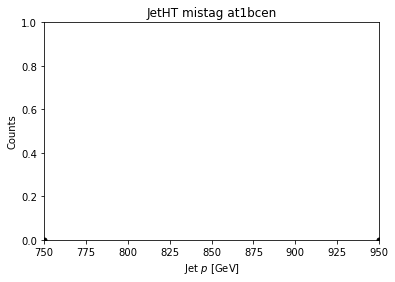

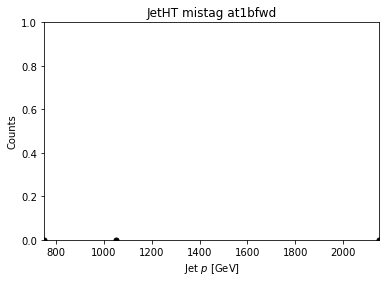

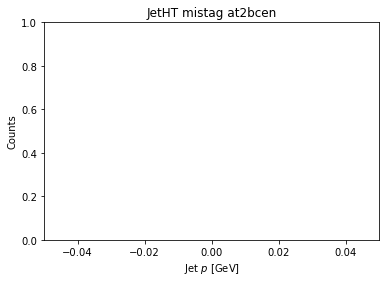

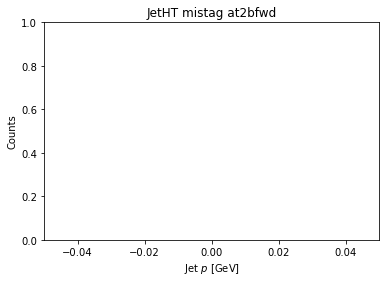

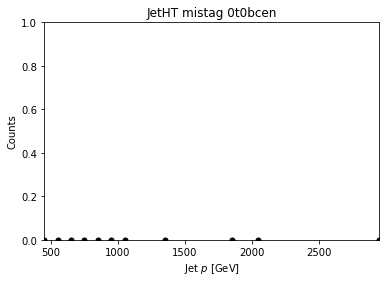

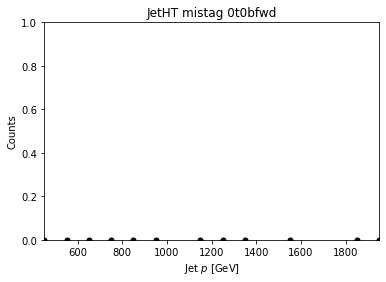

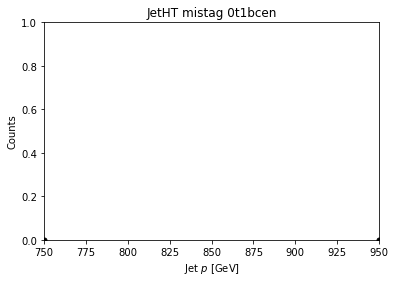

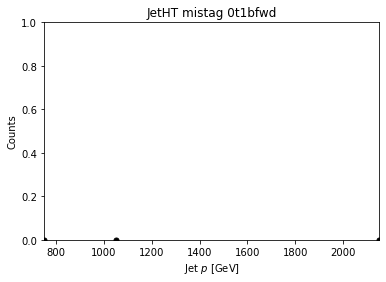

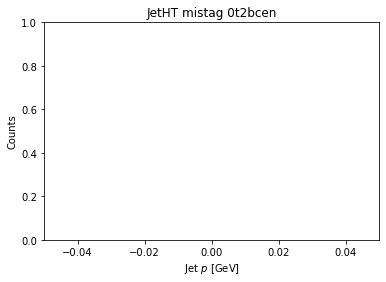

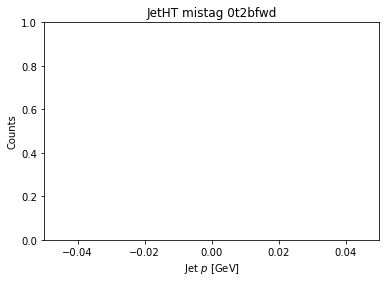

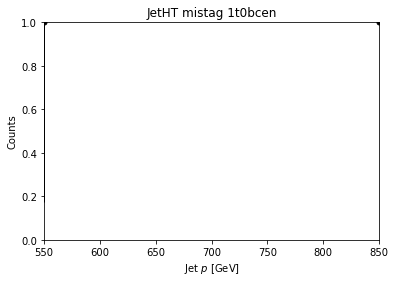

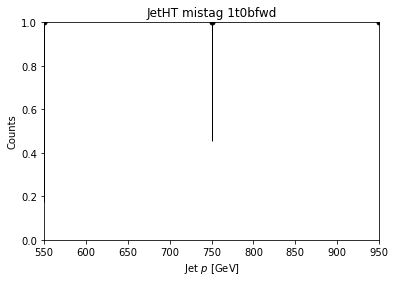

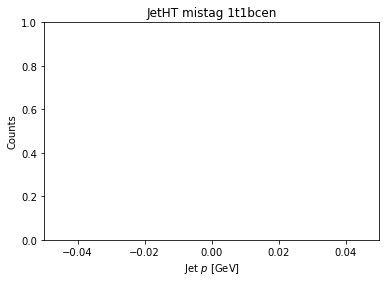

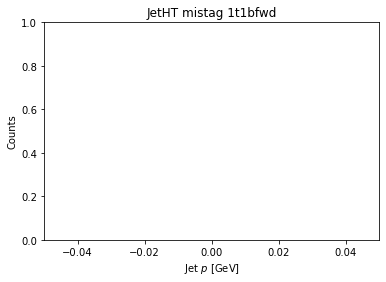

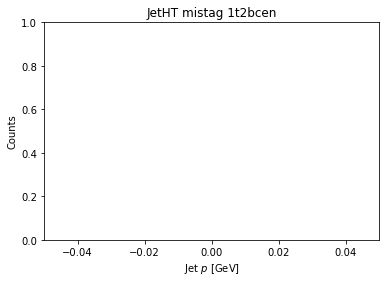

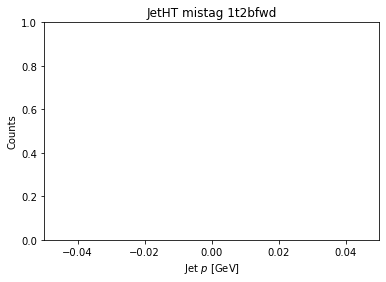

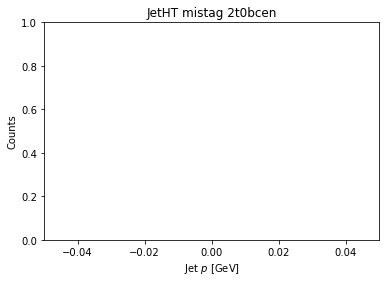

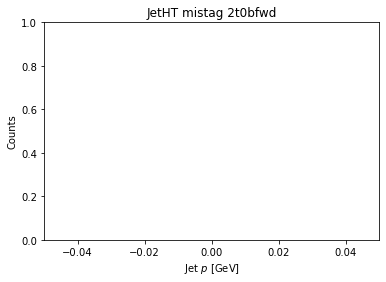

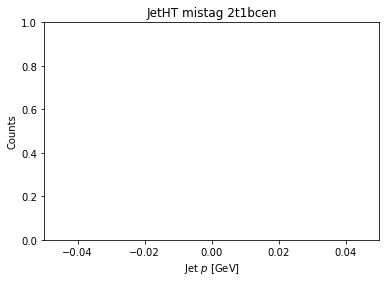

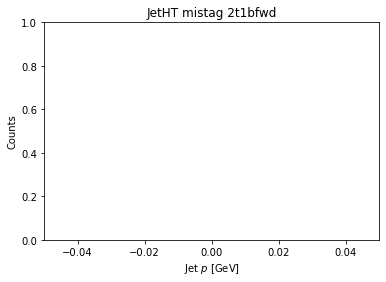

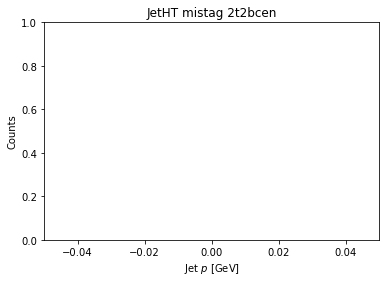

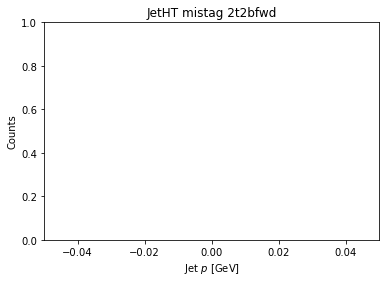

In [28]:
""" ---------------- CREATES MISTAG PLOTS ---------------- """
# ---- Only Use This Cell When LookUp Tables Are Not In Use (i.e. UseLookUpTables = False) ---- #

SaveDirectory = maindirectory + '/MistagPlots/'
DoesDirectoryExist(SaveDirectory) # no need to create the directory several times
print(SaveDirectory)
for iset in filesets:
    for icat in list_of_cats:
        print(iset)
        print(icat)
        title = iset + ' mistag ' + icat
        filename = 'mistag_' + iset + '_' + icat + '.' + 'png'
        print(outputs_unweighted[iset]['numerator'])
        Numerator = outputs_unweighted[iset]['numerator'].integrate('anacat', icat).integrate('dataset', iset)
        Denominator = outputs_unweighted[iset]['denominator'].integrate('anacat', icat).integrate('dataset', iset)
        print(Numerator)
        print(Denominator)
        mistag = hist.plotratio(num = Numerator, denom = Denominator,
                                error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                                unc = 'num')
        plt.title(title)
        plt.ylim(bottom = 0, top = 1.0)
        plt.savefig(SaveDirectory+filename, bbox_inches="tight")
        print(filename + ' saved')

In [29]:
""" ---------------- LOOK UP TABLE ---------------- """
# ---- Only Use This Cell When LookUp Tables Are Not In Use (i.e. UseLookUpTables = False) ---- #

SaveDirectory = maindirectory + '/LookupTables/'
DoesDirectoryExist(SaveDirectory)
for iset in filesets:
    print('\t\tfileset: ' + iset + '\n*****************************************************\n')
    for icat in list_of_cats:
        title = iset + ' mistag ' + icat
        filename = 'mistag_' + iset + '_' + icat + '.' + 'csv'
        
        Numerator = outputs_unweighted[iset]['numerator'].integrate('anacat',icat).integrate('dataset',iset)
        Denominator = outputs_unweighted[iset]['denominator'].integrate('anacat',icat).integrate('dataset',iset)
        
        N_vals = Numerator.values()[()]
        D_vals = Denominator.values()[()]
    
        mistag_vals = np.where(D_vals > 0, N_vals / D_vals, 0)
        
        p_vals = [] # Momentum values
        for iden in Numerator.identifiers('jetp'):
            p_vals.append(iden)
        
        print('fileset:  ' + iset)
        print('category: ' + icat)
        print('________________________________________________\n')

        d = {'p': p_vals, 'M(p)': mistag_vals}
        
        df = pd.DataFrame(data=d)
        
        with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
            print(df)
        print('\n')
        
        df.to_csv(SaveDirectory+filename) # use later to collect bins and weights for re-scaling


		fileset: QCD
*****************************************************

fileset:  QCD
category: at0bcen
________________________________________________

               p      M(p)
0       [0, 100)  0.000000
1     [100, 200)  0.000000
2     [200, 300)  0.000000
3     [300, 400)  0.000000
4     [400, 500)  0.111525
5     [500, 600)  0.000000
6     [600, 700)  0.022950
7     [700, 800)  0.046942
8     [800, 900)  0.041180
9    [900, 1000)  0.000000
10  [1000, 1100)  0.007769
11  [1100, 1200)  0.000000
12  [1200, 1300)  0.010516
13  [1300, 1400)  0.000000
14  [1400, 1500)  0.000000
15  [1500, 1600)  0.000000
16  [1600, 1700)  0.000000
17  [1700, 1800)  0.000000
18  [1800, 1900)  0.576279
19  [1900, 2000)  0.000000
20  [2000, 2100)  0.000000
21  [2100, 2200)  0.014034
22  [2200, 2300)  0.000000
23  [2300, 2400)  0.000000
24  [2400, 2500)  0.000000
25  [2500, 2600)  0.000000
26  [2600, 2700)  0.000000
27  [2700, 2800)  0.000000
28  [2800, 2900)  0.000000
29  [2900, 3000)  0.000000
30  [3000, 

fileset:  QCD
category: 2t1bcen
________________________________________________

               p  M(p)
0       [0, 100)   0.0
1     [100, 200)   0.0
2     [200, 300)   0.0
3     [300, 400)   0.0
4     [400, 500)   0.0
5     [500, 600)   0.0
6     [600, 700)   0.0
7     [700, 800)   0.0
8     [800, 900)   0.0
9    [900, 1000)   0.0
10  [1000, 1100)   0.0
11  [1100, 1200)   0.0
12  [1200, 1300)   0.0
13  [1300, 1400)   0.0
14  [1400, 1500)   0.0
15  [1500, 1600)   0.0
16  [1600, 1700)   0.0
17  [1700, 1800)   0.0
18  [1800, 1900)   0.0
19  [1900, 2000)   0.0
20  [2000, 2100)   0.0
21  [2100, 2200)   0.0
22  [2200, 2300)   0.0
23  [2300, 2400)   0.0
24  [2400, 2500)   0.0
25  [2500, 2600)   0.0
26  [2600, 2700)   0.0
27  [2700, 2800)   0.0
28  [2800, 2900)   0.0
29  [2900, 3000)   0.0
30  [3000, 3100)   0.0
31  [3100, 3200)   0.0
32  [3200, 3300)   0.0
33  [3300, 3400)   0.0
34  [3400, 3500)   0.0
35  [3500, 3600)   0.0
36  [3600, 3700)   0.0
37  [3700, 3800)   0.0
38  [3800, 3900)   0.

fileset:  TTbar
category: 1t2bcen
________________________________________________

               p  M(p)
0       [0, 100)   0.0
1     [100, 200)   0.0
2     [200, 300)   0.0
3     [300, 400)   0.0
4     [400, 500)   0.0
5     [500, 600)   0.0
6     [600, 700)   0.0
7     [700, 800)   0.0
8     [800, 900)   0.0
9    [900, 1000)   0.0
10  [1000, 1100)   0.0
11  [1100, 1200)   0.0
12  [1200, 1300)   0.0
13  [1300, 1400)   0.0
14  [1400, 1500)   0.0
15  [1500, 1600)   0.0
16  [1600, 1700)   0.0
17  [1700, 1800)   0.0
18  [1800, 1900)   0.0
19  [1900, 2000)   0.0
20  [2000, 2100)   0.0
21  [2100, 2200)   0.0
22  [2200, 2300)   0.0
23  [2300, 2400)   0.0
24  [2400, 2500)   0.0
25  [2500, 2600)   0.0
26  [2600, 2700)   0.0
27  [2700, 2800)   0.0
28  [2800, 2900)   0.0
29  [2900, 3000)   0.0
30  [3000, 3100)   0.0
31  [3100, 3200)   0.0
32  [3200, 3300)   0.0
33  [3300, 3400)   0.0
34  [3400, 3500)   0.0
35  [3500, 3600)   0.0
36  [3600, 3700)   0.0
37  [3700, 3800)   0.0
38  [3800, 3900)   

fileset:  JetHT
category: 1t0bcen
________________________________________________

               p  M(p)
0       [0, 100)   0.0
1     [100, 200)   0.0
2     [200, 300)   0.0
3     [300, 400)   0.0
4     [400, 500)   0.0
5     [500, 600)   1.0
6     [600, 700)   0.0
7     [700, 800)   0.0
8     [800, 900)   1.0
9    [900, 1000)   0.0
10  [1000, 1100)   0.0
11  [1100, 1200)   0.0
12  [1200, 1300)   0.0
13  [1300, 1400)   0.0
14  [1400, 1500)   0.0
15  [1500, 1600)   0.0
16  [1600, 1700)   0.0
17  [1700, 1800)   0.0
18  [1800, 1900)   0.0
19  [1900, 2000)   0.0
20  [2000, 2100)   0.0
21  [2100, 2200)   0.0
22  [2200, 2300)   0.0
23  [2300, 2400)   0.0
24  [2400, 2500)   0.0
25  [2500, 2600)   0.0
26  [2600, 2700)   0.0
27  [2700, 2800)   0.0
28  [2800, 2900)   0.0
29  [2900, 3000)   0.0
30  [3000, 3100)   0.0
31  [3100, 3200)   0.0
32  [3200, 3300)   0.0
33  [3300, 3400)   0.0
34  [3400, 3500)   0.0
35  [3500, 3600)   0.0
36  [3600, 3700)   0.0
37  [3700, 3800)   0.0
38  [3800, 3900)   

In [30]:
print("Events/s:", output['cutflow']['all events']/elapsed)

Events/s: 23011.114605441533


In [31]:
tstart = time.time()

fileset = {
    'JetHT':jetdatafiles
}

outputs_weighted = {}

lut = SaveDirectory + 'mistag_JetHT'

output_weighted = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=TTbarResProcessor(UseLookUpTables=True, lu=lut),
                                  #executor=processor.dask_executor,
                                  #executor=processor.iterative_executor,
                                  executor=processor.futures_executor,
                                  executor_args={
                                      'client': client, 
                                      'nano':False, 
                                      'flatten':True, 
                                      'skipbadfiles':False,
                                      'workers': 2},
                                  chunksize=50000, maxchunks=10
                                 )

elapsed = time.time() - tstart
outputs_weighted['JetHT'] = output_weighted
print(output_weighted)
print(elapsed)
util.save(output, 'TTbarResCoffea_weighted_JetHT_output.coffea')

['at0bcen', 'at0bfwd', 'at1bcen', 'at1bfwd', 'at2bcen', 'at2bfwd', '0t0bcen', '0t0bfwd', '0t1bcen', '0t1bfwd', '0t2bcen', '0t2bfwd', '1t0bcen', '1t0bfwd', '1t1bcen', '1t1bfwd', '1t2bcen', '1t2bfwd', '2t0bcen', '2t0bfwd', '2t1bcen', '2t1bfwd', '2t2bcen', '2t2bfwd']



{'ttbarmass': <Hist (dataset,anacat,ttbarmass) instance at 0x7fbab8e58410>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7fbab838b8d0>, 'jetpt': <Hist (dataset,anacat,jetpt) instance at 0x7fbab84d7110>, 'jeteta': <Hist (dataset,anacat,jeteta) instance at 0x7fbab86b7610>, 'jetphi': <Hist (dataset,anacat,jetphi) instance at 0x7fbab84f5810>, 'subjetmass': <Hist (dataset,anacat,subjetmass) instance at 0x7fbab83a3290>, 'subjetpt': <Hist (dataset,anacat,subjetpt) instance at 0x7fba97d75c90>, 'subjeteta': <Hist (dataset,anacat,subjeteta) instance at 0x7fbab80a6110>, 'subjetphi': <Hist (dataset,anacat,subjetphi) instance at 0x7fba97a71350>, 'numerator': <Hist (dataset,anacat,jetp) instance at 0x7fba97a71950>, 'denominator': <Hist (dataset,anacat,jetp) instance at 0x7fba97a71290>, 'cutflow': defaultdict_accumulator(<class 'int'>, {'all events': 499734, 'all JetHT events': 499734, 'number of JetHT sets': 10, 'one FatJets': 5243, 'two FatJets': 5159, 'jet id': 5147, 'jet kin': 3484, '

In [32]:
for name,output in outputs_weighted.items(): 
    print("-------Unweighted " + name + "--------")
    for i,j in output['cutflow'].items():        
        print( '%20s : %12d' % (i,j) )

-------Unweighted JetHT--------
          all events :       499734
    all JetHT events :       499734
number of JetHT sets :           10
         one FatJets :         5243
         two FatJets :         5159
              jet id :         5147
             jet kin :         3484
two FatJets and jet kin :         1642
     >= one oneTTbar :         1642
          dPhi > 2.1 :          803
             at0bcen :           45
             at0bfwd :           41
             at1bcen :            0
             at1bfwd :            3
             at2bcen :            0
             at2bfwd :            0
             0t0bcen :          351
             0t0bfwd :          320
             0t1bcen :           15
             0t1bfwd :           14
             0t2bcen :            0
             0t2bfwd :            0
             1t0bcen :           59
             1t0bfwd :           38
             1t1bcen :            2
             1t1bfwd :            2
             1t2bcen :       